# Phishing Classifier — Combined Retraining

This notebook retrains a **TF‑IDF → Multinomial Naive Bayes** pipeline on a **combined corpus** built from multiple CSV files.

**Flow:**
1. Configure input CSVs in `DATASETS`.
2. Normalize columns & labels across datasets.
3. Concatenate, drop duplicates, split train/test.
4. Train the pipeline and evaluate.
5. Save the best model and metadata to `models/`.
6. Use the standalone eval cell to reload and re-score.

➡️ Add more CSVs to `DATASETS` any time; re-run to include them.

In [2]:
# ==== Imports & Paths ====
import os, json, re, time
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, f1_score
)

from joblib import dump, load

# Directories
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)

REGISTRY_PATH = MODELS_DIR / "registry.json"
BEST_MODEL_PATH = MODELS_DIR / "best_model.joblib"
BEST_META_PATH  = MODELS_DIR / "best_model_meta.json"
TEST_SPLIT_PATH = ARTIFACTS_DIR / "test_split.csv"

print("📁 models →", MODELS_DIR.resolve())
print("📁 artifacts →", ARTIFACTS_DIR.resolve())

📁 models → C:\Users\Dzikry Fauzan R\Downloads\ML DL EDA\phishing_email.csv\models
📁 artifacts → C:\Users\Dzikry Fauzan R\Downloads\ML DL EDA\phishing_email.csv\artifacts


In [3]:
# ==== Configure Datasets ====
# Add/adjust paths here. You can include as many CSVs as you want.
# Each CSV should contain email text + label columns (names are normalized below).
DATASETS = [
    "phishing_email.csv",   # original
    "cleaned_file.csv",     # new
   #"another.csv",         # add more here
]

# Heuristics for column detection
TEXT_CANDIDATES = [
    "text","text_combined","message","email","content","body","raw_text","email_text","Email Text"
]
LABEL_CANDIDATES = [
    "label","target","class","is_phishing","category","spam","phishing","Email Type"
]

def pick_column(cands, cols):
    cols_lower = {c.lower(): c for c in cols}
    for name in cands:
        if name.lower() in cols_lower:
            return cols_lower[name.lower()]
    return None

# Normalize a single dataframe to [text_combined, label] with label ∈ {0,1}
def normalize_df(df, src_name="(unknown)"):
    text_col = pick_column(TEXT_CANDIDATES, df.columns)
    label_col = pick_column(LABEL_CANDIDATES, df.columns)

    if text_col is None:
        raise ValueError(f"[{src_name}] Could not find a text column in {df.columns.tolist()}")
    if label_col is None:
        # If no label is present, create a dummy label (e.g., unlabeled= -1); but we need labels to train.
        raise ValueError(f"[{src_name}] Could not find a label column in {df.columns.tolist()}")

    df = df.rename(columns={text_col: "text_combined", label_col: "label"}).copy()

    # Map label to 0/1 if needed
    if df["label"].dtype == object:
        # String labels — map common patterns
        def map_label(x):
            s = str(x).strip().lower()
            # positive class (phishing)
            if "phish" in s: return 1
            if "spam" in s: return 1
            if s in {"1","true","yes"}: return 1
            # negative class (safe/ham/legit)
            if "safe" in s: return 0
            if "ham" in s: return 0
            if "legit" in s or "legitimate" in s: return 0
            if s in {"0","false","no"}: return 0
            # fallback: try int cast
            try:
                v = int(s)
                return 1 if v == 1 else 0
            except:
                # default safe side: assume non-phishing
                return 0
        df["label"] = df["label"].map(map_label).astype(int)
    else:
        # Numeric labels — coerce to {0,1}
        df["label"] = (df["label"].astype(int) != 0).astype(int)

    # Basic cleaning
    df["text_combined"] = df["text_combined"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

    return df[["text_combined","label"]]

print("✅ Dataset configuration ready.")

✅ Dataset configuration ready.


In [4]:
# ==== Load & Combine ====
frames = []
for p in DATASETS:
    pth = Path(p)
    if not pth.exists():
        raise FileNotFoundError(f"Missing dataset: {pth}")
    df = pd.read_csv(pth)
    # Drop common throwaway index cols
    for junk in ["Unnamed: 0", "index", "Id", "ID"]:
        if junk in df.columns:
            df = df.drop(columns=[junk])
    norm = normalize_df(df, src_name=str(pth.name))
    frames.append(norm)

combined = pd.concat(frames, ignore_index=True)
before = combined.shape[0]
combined = combined.dropna(subset=["text_combined"]).drop_duplicates(subset=["text_combined"]).reset_index(drop=True)
after = combined.shape[0]

print(f"Loaded {len(frames)} datasets → concatenated rows: {before}, after clean/dedup: {after}")
print("Label distribution:", combined["label"].value_counts().to_dict())
combined.head()

Loaded 2 datasets → concatenated rows: 101136, after clean/dedup: 99522
Label distribution: {0: 50195, 1: 49327}


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


# 🔎 Exploratory Data Analysis (EDA) — Phishing Emails
This section analyses the **combined dataset** (`combined`) prepared in the previous cell. It focuses on label balance, text lengths, common tokens, and TF‑IDF indicative terms to inform model design.

In [5]:
# --- EDA: Overview and sanity checks ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

assert 'combined' in globals(), "EDA expects a DataFrame named 'combined' from the Load & Combine step."
req_cols = {'text_combined','label'}
missing = req_cols - set(combined.columns)
if missing:
    raise ValueError(f"Missing required columns for EDA: {missing}")

print("Shape:", combined.shape)
print("Columns:", list(combined.columns))
print("\nNull counts:\n", combined.isna().sum())
display(combined.head(3))


Shape: (99522, 2)
Columns: ['text_combined', 'label']

Null counts:
 text_combined    0
label            0
dtype: int64


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0


Label distribution: {0: 50195, 1: 49327}


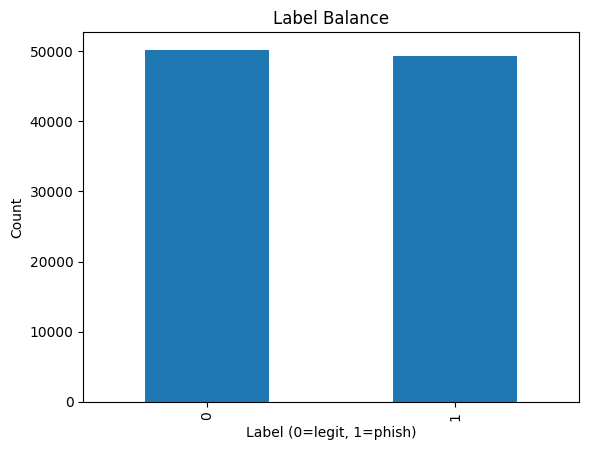

In [6]:
# --- EDA: Class balance ---
counts = combined['label'].value_counts().sort_index()
print("Label distribution:", counts.to_dict())

plt.figure()
counts.plot(kind='bar')
plt.title('Label Balance')
plt.xlabel('Label (0=legit, 1=phish)')
plt.ylabel('Count')
plt.show()


Length stats (by label):


_char_len                                                        \
          count         mean           std  min    25%    50%     75%   
label                                                                   
0       50195.0  1925.691563  66676.651695  7.0  417.0  813.0  1596.0   
1       49327.0  1139.196546  19801.197359  0.0  249.5  432.0  1161.0   

                  _word_len                                              \
              max     count        mean           std  min   25%    50%   
label                                                                     
0      14914828.0   50195.0  302.877079  13833.723209  1.0  61.0  117.0   
1       4279526.0   49327.0  147.121516    596.995269  0.0  34.0   64.0   

                         
         75%        max  
label                    
0      237.0  3096828.0  
1      178.0   107710.0

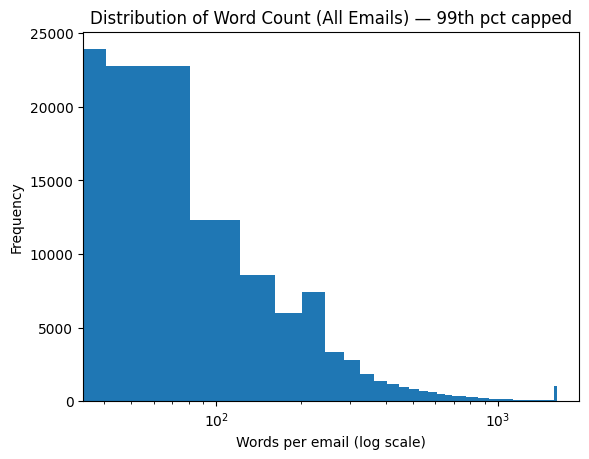

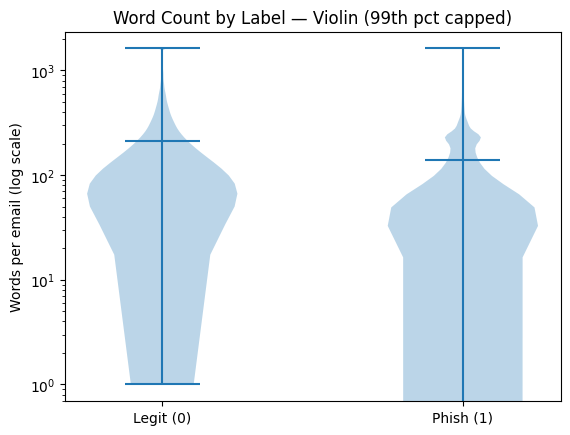

In [7]:
# --- EDA: Text length (chars / words) ---
import numpy as np
import matplotlib.pyplot as plt

# Ensure string then compute lengths
combined['_char_len'] = combined['text_combined'].astype(str).str.len()
combined['_word_len'] = combined['text_combined'].astype(str).str.split().map(len)

print('Length stats (by label):')
display(combined.groupby('label')[['_char_len','_word_len']].describe())

# Cap extreme outliers for nicer plots (99th percentile)
cap = combined['_word_len'].quantile(0.99)
wl_capped = combined['_word_len'].clip(upper=cap)

# Log-scale histogram for all emails
plt.figure()
plt.hist(wl_capped, bins=40)
plt.title('Distribution of Word Count (All Emails) — 99th pct capped')
plt.xlabel('Words per email (log scale)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()

# Violin plot by label (gives density + outliers)
plt.figure()
data0 = combined.loc[combined['label']==0, '_word_len'].clip(upper=cap).dropna().values
data1 = combined.loc[combined['label']==1, '_word_len'].clip(upper=cap).dropna().values
parts = plt.violinplot([data0, data1], showmeans=True, showextrema=True)
plt.xticks([1,2], ['Legit (0)','Phish (1)'])
plt.title('Word Count by Label — Violin (99th pct capped)')
plt.ylabel('Words per email (log scale)')
plt.yscale('log')
plt.show()



=== Correlation Heatmap (Numerical Features) ===


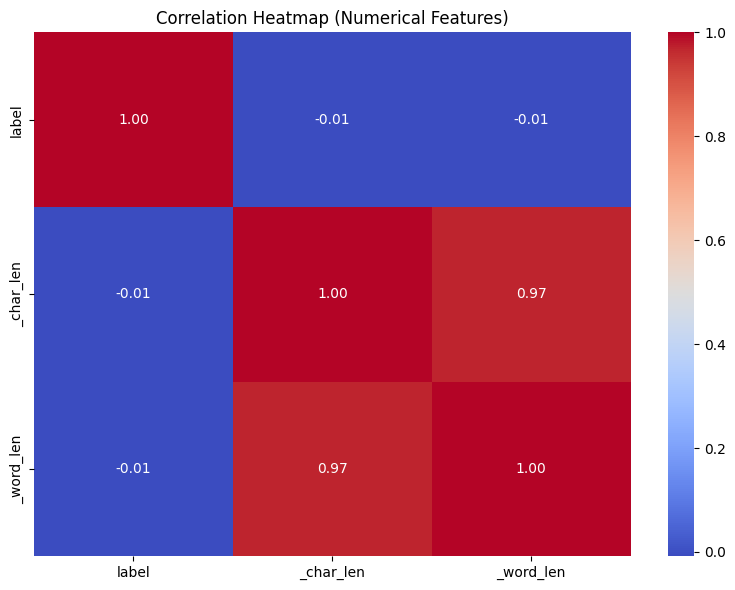


=== Word-Level Correlation Analysis ===


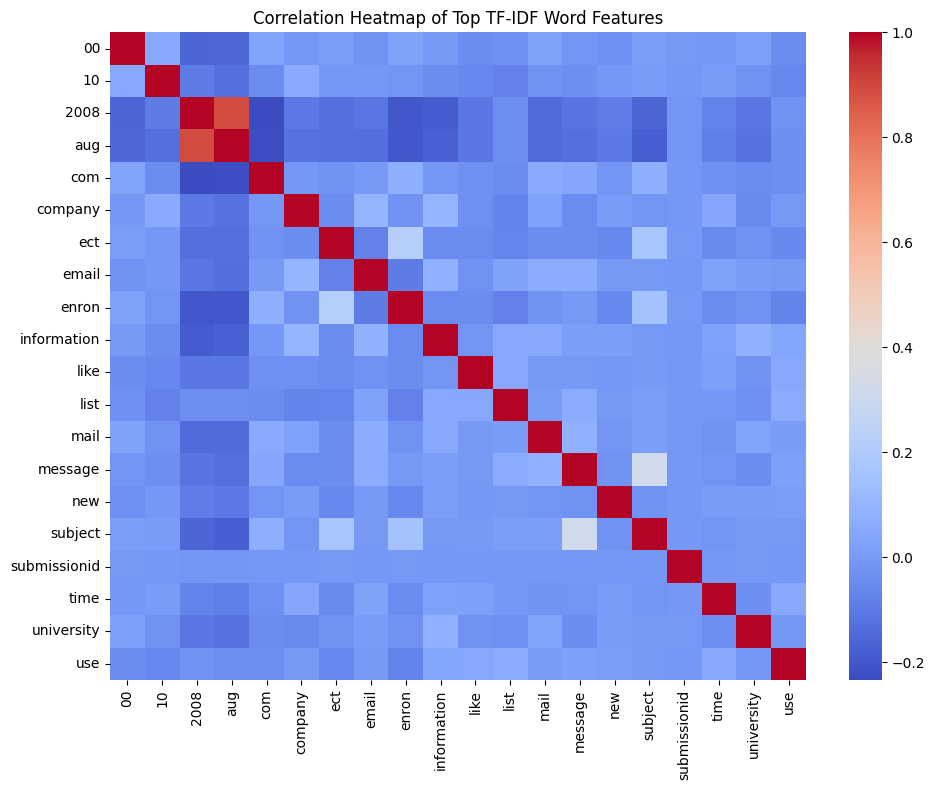

Most correlated words: 2008 & aug (corr=0.89)


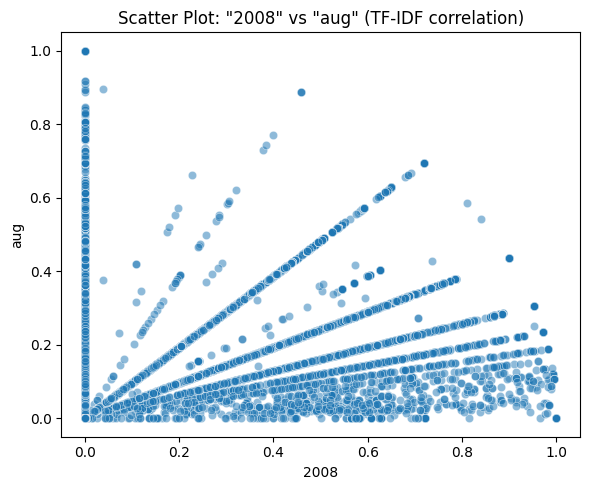

In [8]:
# --- EDA: Correlation Heatmap (Numerical + TF-IDF Word Features) ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

print('\n=== Correlation Heatmap (Numerical Features) ===')
numeric_cols = combined.select_dtypes(include=['number']).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined[numeric_cols].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap (Numerical Features)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numerical features for correlation analysis.')

print('\n=== Word-Level Correlation Analysis ===')
try:
    vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
    X_tfidf = vectorizer.fit_transform(combined['text_combined'].astype(str))
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

    corr_words = tfidf_df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_words, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap of Top TF-IDF Word Features')
    plt.tight_layout()
    plt.show()

    corr_pairs = corr_words.unstack().sort_values(ascending=False)
    corr_pairs = corr_pairs[corr_pairs < 0.9999]
    if not corr_pairs.empty:
        top_pair = corr_pairs.index[0]
        print(f'Most correlated words: {top_pair[0]} & {top_pair[1]} (corr={corr_pairs.iloc[0]:.2f})')
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=tfidf_df[top_pair[0]], y=tfidf_df[top_pair[1]], alpha=0.5)
        plt.title(f'Scatter Plot: "{top_pair[0]}" vs "{top_pair[1]}" (TF-IDF correlation)')
        plt.xlabel(top_pair[0])
        plt.ylabel(top_pair[1])
        plt.tight_layout()
        plt.show()
    else:
        print('No strong correlations among TF-IDF features.')
except Exception as e:
    print('TF-IDF word correlation analysis failed:', e)



Top tokens — Legit (0):
 [('enron', 70532), ('ect', 44825), ('new', 34590), ('university', 32374), ('submissionid', 32246), ('one', 31570), ('please', 31103), ('subject', 27983), ('list', 25356), ('information', 24774), ('also', 23701), ('language', 23642), ('time', 22941), ('like', 22936), ('may', 22906), ('submission', 22863), ('email', 22793), ('com', 22314), ('use', 22176), ('message', 21835)]

Top tokens — Phish (1):
 [('email', 31341), ('httpwwwcnncom', 29358), ('aug', 28060), ('top', 23881), ('company', 21952), ('please', 21689), ('money', 21562), ('one', 19111), ('account', 17717), ('time', 17311), ('news', 17024), ('information', 16556), ('com', 16029), ('get', 15985), ('business', 15067), ('cnncom', 14533), ('new', 14410), ('free', 13802), ('name', 13488), ('click', 13226)]


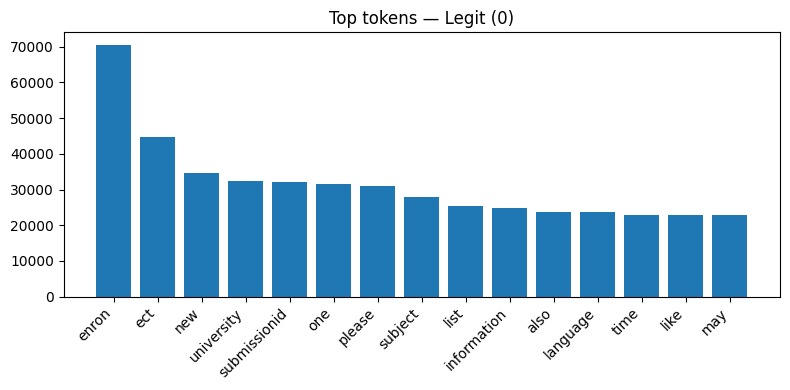

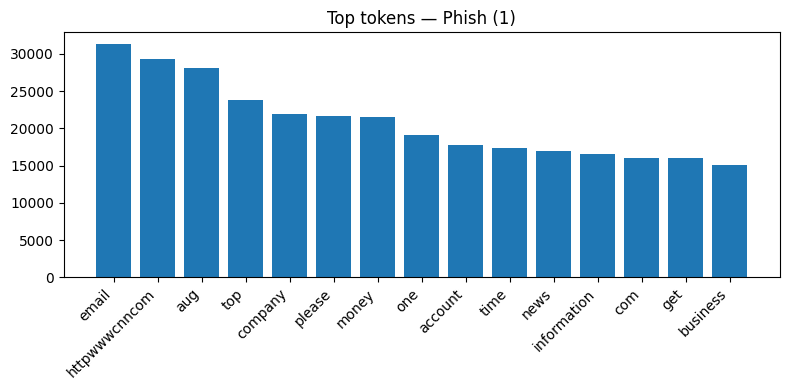

In [9]:
# --- EDA: Common tokens per class ---
import re
from collections import Counter

def tokenize(text):
    return re.findall(r"[a-z]{2,}", str(text).lower())

stop = set("""
a an and are as at be by for from has have in is it its of on or that the this to with you your
i we our us they them he she his her was were will would could should do does did not no yes
""".split())

def top_tokens(series, n=20):
    c = Counter()
    for t in series:
        c.update(w for w in tokenize(t) if w not in stop)
    return c.most_common(n)

top_legit = top_tokens(combined.loc[combined['label']==0,'text_combined'])
top_phish = top_tokens(combined.loc[combined['label']==1,'text_combined'])

print("\nTop tokens — Legit (0):\n", top_legit)
print("\nTop tokens — Phish (1):\n", top_phish)

def bar_top(items, title):
    if not items:
        return
    terms, vals = zip(*items[:15])
    plt.figure(figsize=(8,4))
    plt.bar(range(len(terms)), vals)
    plt.xticks(range(len(terms)), terms, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

bar_top(top_legit, "Top tokens — Legit (0)")
bar_top(top_phish, "Top tokens — Phish (1)")


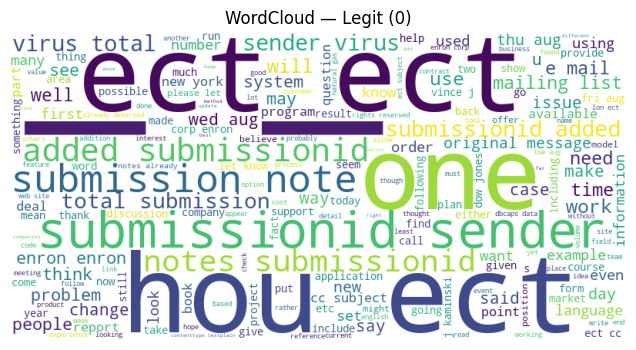

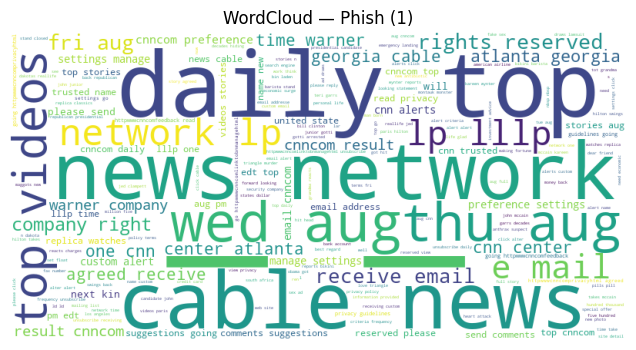

In [10]:
# --- EDA: Wordclouds per label (optional) ---
try:
    try:
        from wordcloud import WordCloud
    except ImportError:
        import os
        print('Installing wordcloud package...')
        os.system('pip install wordcloud')
        from wordcloud import WordCloud

    import matplotlib.pyplot as plt

    def build_text(series):
        return ' '.join(str(x) for x in series.dropna().astype(str).values)

    text_legit = build_text(combined.loc[combined['label']==0,'text_combined'])
    text_phish = build_text(combined.loc[combined['label']==1,'text_combined'])

    wc0 = WordCloud(width=800, height=400, background_color='white').generate(text_legit)
    plt.figure(figsize=(8,4))
    plt.imshow(wc0)
    plt.axis('off')
    plt.title('WordCloud — Legit (0)')
    plt.show()

    wc1 = WordCloud(width=800, height=400, background_color='white').generate(text_phish)
    plt.figure(figsize=(8,4))
    plt.imshow(wc1)
    plt.axis('off')
    plt.title('WordCloud — Phish (1)')
    plt.show()
except Exception as e:
    print('WordCloud not available or failed:', e)


Mean indicator features by label:


,_num_urls,_num_exclaim,_num_dollar,_digit_ratio
label,,,,
Legit (0),0.044188,0.416735,0.374539,0.055231
Phish (1),0.020618,0.446469,0.310053,0.061169


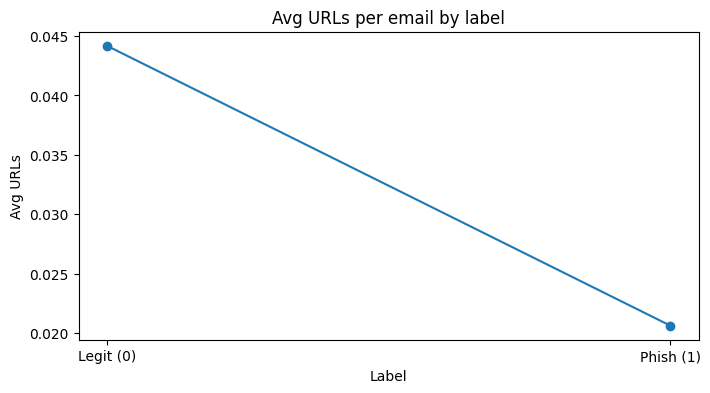

In [11]:
# --- EDA: URL & punctuation features ---
import re
def count_pattern(series, pattern):
    return series.astype(str).str.count(pattern)

# Use raw strings for regex to avoid invalid escape warnings
combined['_num_urls'] = combined['text_combined'].astype(str).str.count(r'(http[s]?://|www\.|\.com)')
combined['_num_exclaim'] = combined['text_combined'].astype(str).str.count(r'!')
combined['_num_dollar'] = combined['text_combined'].astype(str).str.count(r'\$')
combined['_digit_ratio'] = combined['text_combined'].astype(str).apply(lambda s: (sum(ch.isdigit() for ch in s)+1)/(len(s)+1))

summary = combined.groupby('label')[['_num_urls','_num_exclaim','_num_dollar','_digit_ratio']].mean().rename(index={0:'Legit (0)',1:'Phish (1)'})
print('Mean indicator features by label:')
display(summary)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(summary.index, summary['_num_urls'], marker='o')
plt.title('Avg URLs per email by label')
plt.xlabel('Label')
plt.ylabel('Avg URLs')
plt.show()


In [12]:
# --- EDA: TF-IDF indicative terms (insight only; separate from training) ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

texts = combined['text_combined'].astype(str).values
y = combined['label'].astype(int).values

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X = tfidf.fit_transform(texts)

nb = MultinomialNB()
nb.fit(X, y)

feature_names = np.array(tfidf.get_feature_names_out())
log_prob = nb.feature_log_prob_
top_k = 20
phish_idx = np.argsort((log_prob[1] - log_prob[0]))[::-1][:top_k]
legit_idx = np.argsort((log_prob[0] - log_prob[1]))[::-1][:top_k]

print("\nMost indicative for Phish (class 1):")
display(pd.DataFrame({'term': feature_names[phish_idx], 'score': (log_prob[1]-log_prob[0])[phish_idx]}))

print("\nMost indicative for Legit (class 0):")
display(pd.DataFrame({'term': feature_names[legit_idx], 'score': (log_prob[0]-log_prob[1])[legit_idx]}))



Most indicative for Phish (class 1):


,term,score
0,daily top,6.207506
1,replica watches,6.001084
2,replica,5.924073
3,custom alert,5.889312
4,replica classics,5.871468
5,watches,5.602153
6,cnncom,5.573016
7,rolex,5.565893
8,network lp,5.516016
9,lllp,5.516016



Most indicative for Legit (class 0):


,term,score
0,enron,6.971616
1,hou ect,6.286189
2,ect ect,6.209105
3,pythondev,5.942201
4,opensuse,5.756510
5,enron com,5.691146
6,kaminski,5.623065
7,python3000,5.555669
8,hpl,5.540498
9,hourahead,5.496953


> **Note:** The TF‑IDF fit above is for **insight only** and does not affect the official training pipeline below (which performs its own train/test split and model fit). Skip heavy plots on slow machines to save time.

In [13]:
# ==== Train/Test Split ====
X = combined["text_combined"].values
y = combined["label"].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train_raw)}, Test size: {len(X_test_raw)}")

# Save test split for standalone evaluation later
test_df = pd.DataFrame({"text": X_test_raw, "label": y_test})
test_df.to_csv(TEST_SPLIT_PATH, index=False)
print(f"✅ Saved test split to {TEST_SPLIT_PATH}")

Train size: 79617, Test size: 19905
✅ Saved test split to artifacts\test_split.csv


In [14]:
# ==== Build & Train Pipeline (TF-IDF + MultinomialNB) ====
nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", MultinomialNB(alpha=0.3))
])

nb_pipeline.fit(X_train_raw, y_train)
print("✅ Trained MultinomialNB pipeline on combined dataset.")

✅ Trained MultinomialNB pipeline on combined dataset.


In [15]:
# ==== Evaluation ====
def evaluate(model, X_text, y_true):
    y_pred = model.predict(X_text)
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix [rows=true, cols=pred]:\n", cm)
    # prob metrics if available
    f1 = f1_score(y_true, y_pred, average="weighted")
    try:
        if hasattr(model, "predict_proba"):
            # heuristic: assume positive=1
            y_prob = model.predict_proba(X_text)[:, 1]
            roc = roc_auc_score(y_true, y_prob)
            pr  = average_precision_score(y_true, y_prob)
            print(f"ROC AUC: {roc:.4f}")
            print(f"PR  AUC: {pr:.4f}")
    except Exception as e:
        print("AUC calc error:", e)
    return f1

print("=== MultinomialNB (TF-IDF) on TEST ===")
nb_f1_test = evaluate(nb_pipeline, X_test_raw, y_test)
print(f"NB F1 (weighted): {nb_f1_test:.4f}")

=== MultinomialNB (TF-IDF) on TEST ===
              precision    recall  f1-score   support

           0     0.9860    0.9946    0.9903     10039
           1     0.9945    0.9856    0.9900      9866

    accuracy                         0.9902     19905
   macro avg     0.9902    0.9901    0.9902     19905
weighted avg     0.9902    0.9902    0.9902     19905

Confusion matrix [rows=true, cols=pred]:
 [[9985   54]
 [ 142 9724]]
ROC AUC: 0.9995
PR  AUC: 0.9994
NB F1 (weighted): 0.9902


In [16]:
# ==== Save Model, Meta, Registry ====
def _load_registry():
    if REGISTRY_PATH.exists():
        with open(REGISTRY_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {"runs": []}

def _save_registry(reg):
    with open(REGISTRY_PATH, "w", encoding="utf-8") as f:
        json.dump(reg, f, indent=2)

from datetime import datetime, timezone
ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")

# Always save this NB model as the current best for this run
dump(nb_pipeline, BEST_MODEL_PATH)
meta = {
    "timestamp": ts,
    "model_name": "MultinomialNB_TFIDF",
    "metric": "f1_weighted",
    "score": float(nb_f1_test),
    "notes": "Combined retrain (Option B)",
}
with open(BEST_META_PATH, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

reg = _load_registry()
reg["runs"].append({
    "timestamp": ts,
    "model_name": "MultinomialNB_TFIDF",
    "metric": "f1_weighted",
    "score": float(nb_f1_test),
    "saved": True,
    "n_train": int(len(X_train_raw)),
    "n_test": int(len(X_test_raw)),
})
_save_registry(reg)

print(f"✅ Saved BEST model → {BEST_MODEL_PATH}")
print(f"🗒️  Meta → {BEST_META_PATH}")
print(f"📚 Registry updated → {REGISTRY_PATH}")

✅ Saved BEST model → models\best_model.joblib
🗒️  Meta → models\best_model_meta.json
📚 Registry updated → models\registry.json


In [17]:
# ==== Standalone Evaluation (Reload & Score Saved Model) ====
from pathlib import Path
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# 1) Load model + meta
model = load(BEST_MODEL_PATH)
with open(BEST_META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)
print("Loaded model:", meta)

# 2) Load test split
test_path = TEST_SPLIT_PATH
if not test_path.exists():
    raise FileNotFoundError(f"Missing test split at {test_path}. Re-run the split cell above.")
test_df = pd.read_csv(test_path)
X_text = test_df["text"].astype(str).values
y_true = test_df["label"].astype(int).values

# 3) Evaluate
y_pred = model.predict(X_text)
print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Optional prob metrics
try:
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_text)[:, 1]
        print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
        print(f"PR  AUC: {average_precision_score(y_true, y_prob):.4f}")
except Exception as e:
    print("AUC calc error:", e)

Loaded model: {'timestamp': '2025-10-20T23:10:55Z', 'model_name': 'MultinomialNB_TFIDF', 'metric': 'f1_weighted', 'score': 0.9901526569225572, 'notes': 'Combined retrain (Option B)'}
              precision    recall  f1-score   support

           0     0.9860    0.9946    0.9903     10039
           1     0.9945    0.9856    0.9900      9866

    accuracy                         0.9902     19905
   macro avg     0.9902    0.9901    0.9902     19905
weighted avg     0.9902    0.9902    0.9902     19905

Confusion matrix:
 [[9985   54]
 [ 142 9724]]
ROC AUC: 0.9995
PR  AUC: 0.9994


✅ Loaded new dataset: 29767 rows, 3 columns
✅ Loaded saved model: best_model.joblib

📊 Classification report on NEW data:
              precision    recall  f1-score   support

           0     0.9698    0.9992    0.9843     15791
           1     0.9990    0.9649    0.9817     13976

    accuracy                         0.9831     29767
   macro avg     0.9844    0.9820    0.9830     29767
weighted avg     0.9835    0.9831    0.9830     29767

Confusion Matrix:
 [[15778    13]
 [  491 13485]]


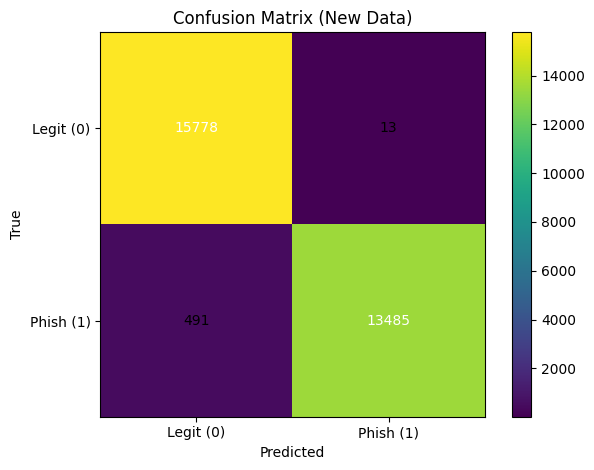


💾 Predictions saved to C:\Users\Dzikry Fauzan R\Downloads\ML DL EDA\phishing_email.csv\artifacts\new_predictions.csv


In [4]:
# ==========================================================
# ==== NEW DATA DEMO: load CSV -> run saved Joblib model ===
# ==========================================================
from pathlib import Path
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# ---------- 1) New CSV ----------
NEW_DATA_PATH = "Enron.csv"   # <-- change this

csv_path = Path(NEW_DATA_PATH)
if not csv_path.exists():
    raise FileNotFoundError(f"Could not find CSV at: {csv_path.resolve()}")

# ---------- 2) Read CSV (robust to encoding hiccups) ----------
try:
    df_new = pd.read_csv(csv_path, encoding="utf-8")
except UnicodeDecodeError:
    df_new = pd.read_csv(csv_path, encoding="latin-1")

print(f"✅ Loaded new dataset: {df_new.shape[0]} rows, {df_new.shape[1]} columns")

# ---------- 3) Build/locate text_combined ----------
# Try common schemas: already combined, text/content, or subject+body.
text_col = None
candidates = ["text_combined", "text", "content", "message", "email_text"]
for c in candidates:
    if c in df_new.columns:
        text_col = c
        break

if text_col is None:
    subj = "subject" if "subject" in df_new.columns else None
    body = "body" if "body" in df_new.columns else None
    if subj and body:
        df_new["text_combined"] = df_new[subj].fillna("").astype(str) + " " + df_new[body].fillna("").astype(str)
        text_col = "text_combined"
    else:
        raise ValueError(
            "No text column found. Expected one of "
            f"{candidates} or (subject + body). Columns present: {list(df_new.columns)[:20]}"
        )

X_new = df_new[text_col].astype(str).values

# ---------- 4) Load saved model ----------
BEST_MODEL_PATH = Path("models") / "best_model.joblib"
if not BEST_MODEL_PATH.exists():
    raise FileNotFoundError(f"Saved model not found at {BEST_MODEL_PATH.resolve()}")

model = load(BEST_MODEL_PATH)
print("✅ Loaded saved model:", BEST_MODEL_PATH.name)

# ---------- 5) Predict ----------
y_pred = model.predict(X_new)

# ---------- 6) If labels exist, evaluate; else show top predictions ----------
# Try to coerce labels if present (works with 0/1 or ham/spam-like strings)
def coerce_labels(series):
    if series.dtype.kind in "iu":   # int/uint
        return series.astype(int)
    s = series.astype(str).str.lower().str.strip()
    mapping = {
        "phishing": 1, "spam": 1, "malicious": 1, "1": 1, "true": 1,
        "legitimate": 0, "ham": 0, "benign": 0, "0": 0, "false": 0
    }
    return s.map(lambda x: mapping.get(x, np.nan))

has_labels = "label" in df_new.columns
if has_labels:
    y_true = coerce_labels(df_new["label"])
    if y_true.isna().any():
        print("⚠️ Detected non-standard labels; proceeding with raw comparison may be unreliable.")
        # Try again without evaluation if labels can't be coerced well:
        has_labels = False

if has_labels:
    print("\n📊 Classification report on NEW data:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Heatmap-style plot with matplotlib only (no seaborn needed)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (New Data)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Legit (0)","Phish (1)"])
    plt.yticks(tick_marks, ["Legit (0)","Phish (1)"])
    # add counts
    thresh = cm.max() / 2 if cm.max() else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
else:
    df_new["pred"] = y_pred
    df_new["pred_label"] = df_new["pred"].map({1: "Phishing", 0: "Legitimate"})
    print("\n🔎 Sample predictions (no true labels found):")
    display_cols = [c for c in [text_col, "pred_label"] if c in df_new.columns]
    print(df_new[display_cols].head(10))

# ---------- 7) Save predictions ----------
os.makedirs("artifacts", exist_ok=True)
out_path = Path("artifacts") / "new_predictions.csv"
df_new_out = df_new.copy()
df_new_out["pred"] = y_pred
df_new_out["pred_label"] = df_new_out["pred"].map({1: "Phishing", 0: "Legitimate"})
df_new_out.to_csv(out_path, index=False)
print(f"\n💾 Predictions saved to {out_path.resolve()}")
